### **Fake News Detection**
Group No. - 14 <br>
Member 1: Sai Aakash Vydana<br>
Member 2: Devi Varaprasad Jonnala<br>




In [ ]:
!pip install datasets

In [ ]:
!pip install nltk

In [ ]:
from datasets import load_dataset

dataset = load_dataset("liar")

In [ ]:
import os
import re
import nltk
import torch
import math
import time
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from typing import Tuple, List
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
nltk.download('stopwords')


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_data = pd.DataFrame(dataset["train"])
test_data = pd.DataFrame(dataset["test"])
val_data = pd.DataFrame(dataset["validation"])

nb_train_samples = len(train_data)
nb_val_samples = len(val_data)
nb_test_samples = len(test_data)

nb_train_samples, nb_val_samples, nb_test_samples

(10269, 1284, 1283)

In [ ]:
columns_to_concat = ['statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'context']
columns_to_retain = ['label', 'combined_text', 'mostly_true_counts', 'barely_true_counts', 'half_true_counts', 'false_counts', 'pants_on_fire_counts']

def replace_missing(value):
    if value in [None, '', np.nan]:
        return 'none'
    return value


for dataset in [train_data, val_data, test_data]:
    dataset[dataset.columns[1:]] = dataset[dataset.columns[1:]].applymap(replace_missing)
    dataset['combined_text'] = dataset.apply(lambda x: ' '.join(x[col] for col in columns_to_concat if not pd.isnull(x[col])), axis=1)
    dataset.drop(columns=[col for col in dataset.columns if col not in columns_to_retain], inplace=True)

def transform_labels(label):
    # Merging categories 0, 1, 4, 5 into category 0 and categories 2, 3 into category 1
    if label in [2, 3]:
        return 1
    else:
        return 0

train_data['label'] = train_data['label'].apply(transform_labels)
val_data['label'] = val_data['label'].apply(transform_labels)
test_data['label'] = test_data['label'].apply(transform_labels)


In [ ]:
combined_data = pd.concat([train_data, val_data, test_data])
combined_data.shape

(12836, 7)

In [ ]:
# Preprocessing and cleaning the text data

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = text.split()
    required_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(required_tokens)

def preprocess(text):
    # Here we convert the text to lowercase
    text = text.lower()
    # Here we remove the @ and #
    text = re.sub(r'\@\w+|\#',' ', text)
    # Here we remove the punctutions
    text = re.sub(r'[^\w\s]', ' ', text)
    # Here we remove the numbers
    text = re.sub(r'\d+', '', text)
    # Here we remove the stop words
    text = remove_stopwords(text)
    return text

combined_data['combined_text'] = combined_data['combined_text'].apply(preprocess)
combined_data.head()

,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,combined_text
0,0,0.0,1.0,0.0,0.0,0.0,says annies list political group supports thir...
1,0,0.0,0.0,1.0,1.0,0.0,decline coal start started natural gas took st...
2,1,70.0,71.0,160.0,163.0,9.0,hillary clinton agrees john mccain voting give...
3,0,7.0,19.0,3.0,5.0,44.0,health care reform legislation likely mandate ...
4,0,15.0,9.0,20.0,19.0,2.0,economic turnaround started end term economy j...


In [ ]:
from collections import Counter

# The tokenize function to convert text to tokens
def tokenize(dataframe, text_column):

    def find_text(text):
        return re.findall(r'\b\w+\b', text)

    word_index = {}
    index_word = {}

    # Counting teh words using Counter
    word_counts = Counter()
    for text in dataframe[text_column]:
        words = find_text(text)
        word_counts.update(words)

    # Here we assign indices to words based on their frequency
    sorted_words = [word for word, _ in word_counts.most_common()]
    for i, word in enumerate(sorted_words):
        word_index[word] = i + 1

    # Tokenize text and convert it into indices based on the built word index
    def convert_to_indices(text):
        words = find_text(text)
        return [word_index.get(word, 0) for word in words]

    # Apply the conversion to all rows in the specified column of the dataframe
    dataframe['token'] = dataframe[text_column].apply(convert_to_indices)
    return dataframe,len(word_index)


combined_data, dataset_vocabulary_size = tokenize(combined_data, 'combined_text')

combined_data.head()

,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,combined_text,token
0,0,0.0,1.0,0.0,0.0,0.0,says annies list political group supports thir...,"[5, 6692, 890, 198, 270, 511, 451, 6693, 764, ..."
1,0,0.0,0.0,1.0,1.0,0.0,decline coal start started natural gas took st...,"[1988, 1066, 1040, 803, 996, 331, 264, 803, 20..."
2,1,70.0,71.0,160.0,163.0,9.0,hillary clinton agrees john mccain voting give...,"[78, 61, 4222, 51, 144, 145, 489, 215, 147, 13..."
3,0,7.0,19.0,3.0,5.0,44.0,health care reform legislation likely mandate ...,"[7, 11, 324, 407, 862, 863, 485, 621, 171, 550..."
4,0,15.0,9.0,20.0,19.0,2.0,economic turnaround started end term economy j...,"[346, 4770, 803, 528, 633, 19, 20, 291, 342, 1..."


In [ ]:
X_pad = pad_sequence([torch.tensor(tokens) for tokens in combined_data['token']], batch_first=True)

X_true_false_count = torch.tensor(combined_data[['mostly_true_counts', 'half_true_counts', 'barely_true_counts', 'false_counts', 'pants_on_fire_counts']].values, dtype=torch.float)

# Converting labels to PyTorch tensors
y_tensor = torch.squeeze(torch.tensor([item for item in combined_data.iloc[:, 0]]))


indices = list(range(len(combined_data)))
# Getting indices to split into
train_indices = indices[:nb_train_samples]
val_indices = indices[nb_train_samples:nb_train_samples+nb_val_samples]
test_indices = indices[nb_train_samples+nb_val_samples:nb_train_samples+nb_val_samples+nb_test_samples]

class StatementsDataset(Dataset):
    def __init__(self, X_pad, X_true_false_count, y_tensor, indices):
        self.X_pad = X_pad
        self.X_true_false_count = X_true_false_count
        # self.X_true_count = X_true_count
        self.y_tensor = y_tensor
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        inputs = (self.X_pad[index], self.X_true_false_count[index])
        label = self.y_tensor[index]
        return inputs, label

train_dataset = StatementsDataset(X_pad,  X_true_false_count, y_tensor, train_indices)
val_dataset = StatementsDataset(X_pad,  X_true_false_count, y_tensor, val_indices)
test_dataset = StatementsDataset(X_pad,  X_true_false_count, y_tensor, test_indices)

# Defining batch size
batch_size = 64

# Create data loaders for the pytorch datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes=2, d_model=100, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.4):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(input_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        self.layer_norm = nn.LayerNorm(d_model)  # Layer normalization after embedding
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            norm_first=True  # Apply normalization before the rest of the operations in each layer
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 64)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x) * math.sqrt(self.d_model)
        embedded = self.pos_encoding(embedded)
        embedded = self.layer_norm(embedded)  # Apply layer normalization
        output = self.transformer_encoder(embedded)
        output = self.dropout(output)
        output = self.fc(output.mean(dim=1))
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class CustomModel(nn.Module):
    def __init__(self, in_vocab_size, embedding_dim, hidden_dim, num_classes):
        super(CustomModel, self).__init__()

        # Define the embedding layers for the various inputs
        # self.embedding = nn.Embedding(in_vocab_size, embedding_dim)
        self.num_classes = num_classes
        self.vocab_size = in_vocab_size
        self.hidden_dim = hidden_dim

        # statement transformer
        self.transformer_statement = TransformerModel(in_vocab_size)

        #FC for true false counts
        self.mlp = nn.Sequential(nn.Linear(5, 128), nn.ReLU(), nn.Dropout(p=0.1), nn.Linear(128,4))
        self.fc = nn.Sequential(nn.Linear(68,32), nn.Dropout(p=0.1), nn.ReLU(), nn.Linear(32,2), nn.Dropout(p=0.1))


    def forward(self, X_text, X_true_false_count):
        # Embed the statement
        statement_attn = self.transformer_statement(X_text)

        mlp_out = self.mlp(X_true_false_count)

        fc_in = torch.cat((statement_attn, mlp_out), 1)

        output = self.fc(fc_in)
        return output


In [ ]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = CustomModel(dataset_vocabulary_size+1, 128, 200, 2)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
model

CustomModel(
  (transformer_statement): TransformerModel(
    (embedding): Embedding(15446, 100)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
          )
          (linear1): Linear(in_features=100, out_features=256, bias=True)
          (dropout): Dropout(p=0.4, inplace=False)
          (linear2): Linear(in_features=256, out_features=100, bias=True)
          (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.4, inplace=False)
          (dropout2): Dropout(p=0.4, inplace=False)
        )
   

In [ ]:
# Defining array to store training/validation accuracy and loss
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []


start = time.time()
epochs = 100
best_val_loss = float('inf')
patience = 5
patience_count =0

# training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    training_correct_pred = 0

    for inputs, labels in train_loader:
        inputs_list = [input.to(device) for input in inputs]
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(*inputs_list)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
        _, predicted = torch.max(outputs.data, 1)
        training_correct_pred += (predicted == labels).sum().item()

    # Calculating the training accuracy and training loss
    train_loss /= len(train_loader.dataset)
    train_accuracy = training_correct_pred / len(train_loader.dataset)
    training_losses.append(train_loss)
    training_accuracies.append(train_accuracy)

    model.eval()
    validation_loss = 0.0
    validation_correct_pred = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs_list = [input.to(device) for input in inputs]
            labels = labels.to(device)
            outputs = model(*inputs_list)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            validation_correct_pred += (predicted == labels).sum().item()

    # Calculating validation accuracy and validation loss
    validation_loss /= len(val_loader.dataset)
    validation_accuracy = validation_correct_pred / len(val_loader.dataset)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch + 1}: Training Accuracy: {train_accuracy:.4f}, Training Loss: {train_loss:.4f}, '
          f'Validation Accuracy: {validation_accuracy:.4f}, Validation Loss: {validation_loss:.4f}')

    if validation_loss < best_val_loss:
      best_val_loss = validation_loss
      patience_count =0
    else:
      patience_count +=1
      if patience_count >= patience:
        print("Early stopping due to lack of improvement in validation loss")
        break

finish = time.time()
print("Time taken to train the model: ", finish - start,'s')

Epoch 1: Training Accuracy: 0.6351, Training Loss: 0.0104, Validation Accuracy: 0.6729, Validation Loss: 0.0103
Epoch 2: Training Accuracy: 0.6442, Training Loss: 0.0101, Validation Accuracy: 0.6729, Validation Loss: 0.0103
Epoch 3: Training Accuracy: 0.6458, Training Loss: 0.0100, Validation Accuracy: 0.6729, Validation Loss: 0.0102
Epoch 4: Training Accuracy: 0.6440, Training Loss: 0.0100, Validation Accuracy: 0.6706, Validation Loss: 0.0101
Epoch 5: Training Accuracy: 0.6438, Training Loss: 0.0098, Validation Accuracy: 0.6729, Validation Loss: 0.0100
Epoch 6: Training Accuracy: 0.6435, Training Loss: 0.0098, Validation Accuracy: 0.6729, Validation Loss: 0.0101
Epoch 7: Training Accuracy: 0.6451, Training Loss: 0.0097, Validation Accuracy: 0.6737, Validation Loss: 0.0098
Epoch 8: Training Accuracy: 0.6499, Training Loss: 0.0096, Validation Accuracy: 0.6838, Validation Loss: 0.0097
Epoch 9: Training Accuracy: 0.6506, Training Loss: 0.0096, Validation Accuracy: 0.6939, Validation Loss:

In [ ]:
# Model evaluation on the test dataset
model.eval()
test_predictions = []
test_labels = []
testing_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs_list = [input.to(device) for input in inputs]
        labels = labels.to(device)

        outputs = model(*inputs_list)
        _, predictions = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        testing_loss += loss.item()

        test_predictions.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_predictions)
testing_loss = testing_loss/len(test_loader.dataset)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {testing_loss}")
print("Classification Report: ")
print(classification_report(test_labels, test_predictions))

Test Accuracy: 0.7287607170693686
Test Loss: 0.008642055878208097
Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       823
           1       0.69      0.44      0.54       460

    accuracy                           0.73      1283
   macro avg       0.71      0.67      0.67      1283
weighted avg       0.72      0.73      0.71      1283



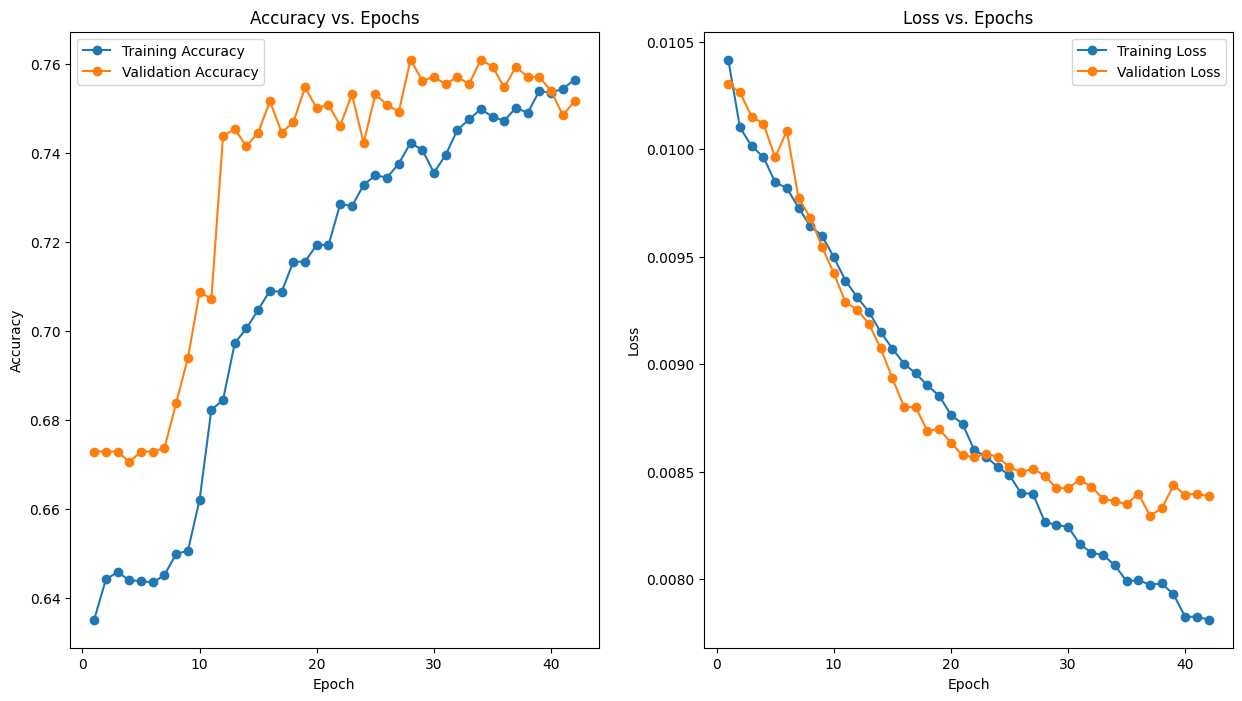

In [ ]:
epochs = range(1, len(training_accuracies) + 1)

fig, axs = plt.subplots(1, 2, figsize=(15,8))
axs[0].plot(epochs, training_accuracies, label='Training Accuracy', marker='o')
axs[0].plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o')
axs[0].set_title('Accuracy vs. Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()


axs[1].plot(epochs, training_losses, label='Training Loss', marker='o')
axs[1].plot(epochs, validation_losses, label='Validation Loss', marker='o')
axs[1].set_title('Loss vs. Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()